In [1]:
#download zip file containing training data for human and horses
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
#     -O /tmp/horse-or-human.zip

In [2]:
#download zip file containing validation data for human and horses
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
#     -O /tmp/validation-horse-or-human.zip

In [3]:
# import OS-related libraries and unzip data
import os
import zipfile

from PIL import Image
import numpy as np

# import tensorflow, keras libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plot some samples
%matplotlib inline

In [4]:
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

The contents of the .zip are extracted to the base directory /tmp/horse-or-human and validation-horse-or-human, which in turn each contain horses and humans subdirectories.

Note 1: The training set tells the neural network model that 'this is what a horse looks like', 'this is what a human looks like' etc.

Note 2:  Horses or human images are not explicitly labeled. Later an ImageGenerator is used that is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. So, for example, you will have a 'training' directory containing a 'horses' directory and a 'humans' one. ImageGenerator will label the images appropriately for you, reducing a coding step.

Let's define each of these directories:

In [5]:
# directory containing training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# directory containing training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

In [6]:
# check directory contents
train_horse_names = os.listdir(train_horse_dir)
print('Number of training horse samples:', len(train_horse_names))
print(train_horse_names[:4])
validation_horse_names = os.listdir(validation_horse_dir)
print('Number of validation horse samples:', len(validation_horse_names))
print(validation_horse_names[:4])

train_human_names = os.listdir(train_human_dir)
print('\nNumber of training human samples:', len(train_human_names))
print(train_human_names[:4])
validation_human_names = os.listdir(validation_human_dir)
print('\nNumber of training human samples:', len(validation_human_names))
print(validation_human_names[:4])

Number of training horse samples: 628
['horse43-5.png', 'horse06-5.png', 'horse20-6.png', 'horse04-7.png']
Number of validation horse samples: 128
['horse1-204.png', 'horse2-112.png', 'horse3-498.png', 'horse5-032.png']

Number of training human samples: 655
['human17-22.png', 'valhuman04-20.png', 'valhuman03-01.png', 'human10-17.png']

Number of training human samples: 128
['valhuman04-20.png', 'valhuman03-01.png', 'valhuman04-08.png', 'valhuman03-15.png']


['/tmp/horse-or-human/horses/horse43-5.png', '/tmp/horse-or-human/horses/horse06-5.png', '/tmp/horse-or-human/horses/horse20-6.png', '/tmp/horse-or-human/horses/horse04-7.png', '/tmp/horse-or-human/horses/horse41-7.png', '/tmp/horse-or-human/horses/horse22-4.png', '/tmp/horse-or-human/horses/horse19-2.png', '/tmp/horse-or-human/horses/horse24-2.png']
['/tmp/horse-or-human/humans/human17-22.png', '/tmp/horse-or-human/humans/valhuman04-20.png', '/tmp/horse-or-human/humans/valhuman03-01.png', '/tmp/horse-or-human/humans/human10-17.png', '/tmp/horse-or-human/humans/valhuman04-08.png', '/tmp/horse-or-human/humans/human10-03.png', '/tmp/horse-or-human/humans/valhuman03-15.png', '/tmp/horse-or-human/humans/human07-27.png']


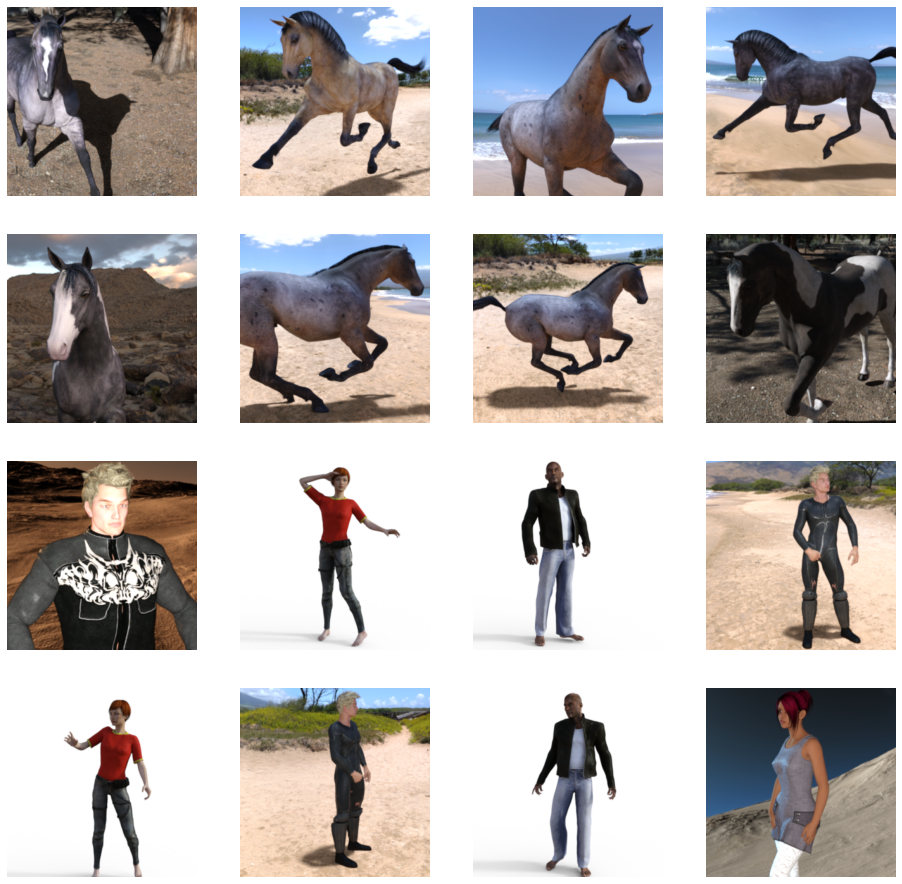

In [7]:
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

sample_horses_pics = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[0:8]]
print(sample_horses_pics)
sample_humans_pics = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[0:8]]
print(sample_humans_pics)

for i, img_path in enumerate(sample_horses_pics+sample_humans_pics):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [8]:
# build model
model = Sequential([
    # first convolution and maxpooling layers
    Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),  # changed input size from 300 to 150
    MaxPooling2D(2, 2),
    # second convolution and maxpooling layers
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # third convolution and maxpooling layers
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # fourth convolution and maxpooling layers
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # fifth convolution and maxpooling layers
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # flatten latest layer output to feed FCN
    Flatten(),
    # first FCN
    Dense(512, activation='relu'),
    # Last FCN with only one neuron and 'sigmoid' activation for binary classification
    Dense(1, activation='sigmoid')    
])

In [9]:
model.summary()  # prints CNN-model architecture 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        3

In [10]:
# compile the model
model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=0.01),
             metrics=['accuracy'])

# Data Preprocessing using generators
In the following, set up data generators that convert input images to 'float32' tensors and feed them to the network. 

Using these generators, preprocess the data by normalizing pixel values to range between [0, 1]. This can be done via keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This class instantiates generators of augmented image batches via .flow(data, labels) or .flow_from_directory(directory). These generators can be used with Keras model methods including fit, evaluate_generator, predict_generator



In [11]:
# set up train and validation data generators
# images rescaled between [0, 1]
train_datagen = ImageDataGenerator(rescale=1/255)  
validation_datagen = ImageDataGenerator(rescale=1/255)

# flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    '/tmp/horse-or-human/',  # source directory for training images
    target_size = (150, 150),  # changed input size from 300x300 to 150x150
    batch_size = 128,
    # For binary_crossentropy loss, we need binary labels
    class_mode='binary')

# flow validation images in batches of 32 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    '/tmp/validation-horse-or-human/',  # source directory for training images
    target_size = (150, 150),  # changed input size from 300x300 to 150x150
    batch_size = 32,
    # For binary_crossentropy loss, we need binary labels
    class_mode='binary')

Found 1283 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [12]:
# train the model
history = model.fit(
    train_generator,
    steps_per_epoch=8,
    epochs=15,
    validation_data=validation_generator,
    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 8 steps
Epoch 1/15
8/8 [==============================] - 12s 2s/step - loss: 117.3566 - accuracy: 0.5061 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 12s 2s/step - loss: 0.6925 - accuracy: 0.4941 - val_loss: 0.6815 - val_accuracy: 0.5000
Epoch 3/15
8/8 [==============================] - 11s 1s/step - loss: 0.6948 - accuracy: 0.5128 - val_loss: 0.6281 - val_accuracy: 0.5000
Epoch 4/15
8/8 [==============================] - 12s 2s/step - loss: 0.6330 - accuracy: 0.6074 - val_loss: 0.3332 - val_accuracy: 0.8711
Epoch 5/15
8/8 [==============================] - 11s 1s/step - loss: 0.7779 - accuracy: 0.5551 - val_loss: 0.9378 - val_accuracy: 0.5000
Epoch 6/15
8/8 [==============================] - 12s 2s/step - loss: 0.6918 - accuracy: 0.6363 - val_loss: 0.7569 - val_accuracy: 0.6016
Epoch 7/15
8/8 [==============================] - 12s 1s/step - loss: 0.6443 - a

In [20]:
from tensorflow.keras.preprocessing import image
# predict test image
test_image = '/Users/gveni/Documents/data/cv_data/testhorse2.jpg'
img = image.load_img(test_image, target_size=(150,150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
class_prediction = model.predict(images)
print(class_prediction[0])
if class_prediction[0] > 0.5:
    print(test_image + ' is a human')
else:
    print(test_image + ' is a horse')

[0.]
/Users/gveni/Documents/data/cv_data/testhorse2.jpg is a horse


/Users/gveni/opt/anaconda3/envs/tensorflowkeras_learning/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


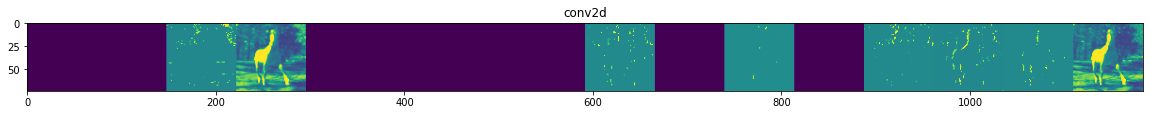

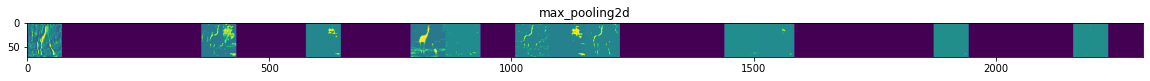

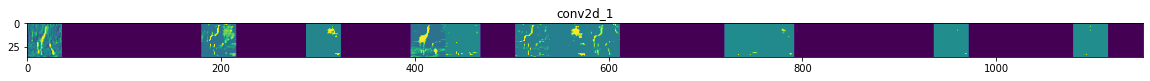

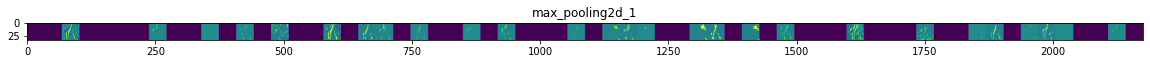

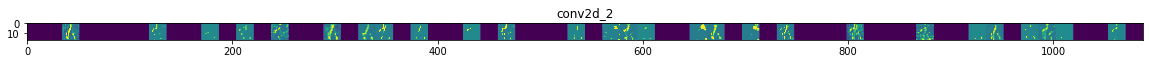

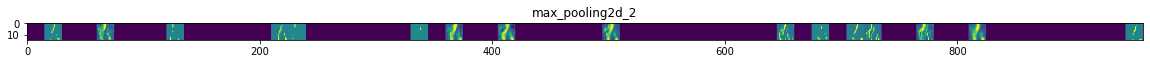

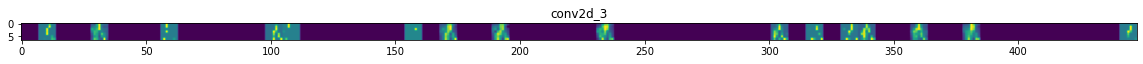

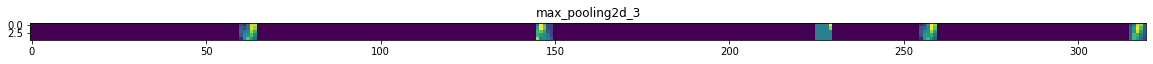

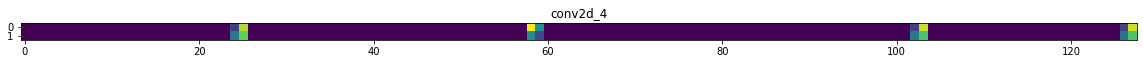

In [24]:
# visualize intermediate representatations
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

layer_outputs = [layer.output for layer in model.layers[1:]]
activation_model = tf.keras.models.Model(inputs=model.input,outputs=layer_outputs)

# pick random images from horse and human folder to see intermediate outputs
horse_images = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_images = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_images + human_images)

img = load_img(img_path, target_size=(150, 150))  # changed input size from 300 to 150
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

# rescale input
x /= 255

feature_maps = activation_model.predict(x)  # intermediate representations of a given input
layer_names = [layer.name for layer in model.layers]  # layer names

# display representations
for layer_name, feature_map in zip(layer_names, feature_maps):
    if len(feature_map.shape) == 4:  # make sure to use outputs from conv/maxpooling layers
        num_features = feature_map.shape[-1]  # feature map shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # Tile images in this matrix
        display_grid = np.zeros((size, size * num_features))
        for i in range(num_features):
          # Postprocess the feature to make it visually palatable
          x = feature_map[0, :, :, i]
          x -= x.mean()
          x /= x.std()
          x *= 64
          x += 128
          x = np.clip(x, 0, 255).astype('uint8')
          # Tile each filter into this big horizontal grid
          display_grid[:, i * size : (i + 1) * size] = x
        # Display the grid
        scale = 20. / num_features
        plt.figure(figsize=(scale * num_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
import signal
os.kill(os.getpid(), signal.SIGKILL)